In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from textblob import TextBlob


In [124]:
#Load and Inspect Data
url = "https://drive.google.com/file/d/1SJcoCmSKSv2lRfdyKpiypk1cUBaLBD6C/view?usp=sharing"
file_id = url.split('/')[-2]
download_url = f"https://drive.google.com/uc?export=download&id={file_id}"

df = pd.read_csv(download_url)
df.head()
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196727 entries, 0 to 196726
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Review Id    196727 non-null  object
 1   Review       196721 non-null  object
 2   Ratings      196727 non-null  int64 
 3   Review Date  196727 non-null  object
dtypes: int64(1), object(3)
memory usage: 6.0+ MB


,Ratings
count,196727.000000
mean,4.503535
std,1.083004
min,1.000000
25%,5.000000
50%,5.000000
75%,5.000000
max,5.000000


In [125]:
print(df.isnull().sum())

Review Id      0
Review         6
Ratings        0
Review Date    0
dtype: int64


In [126]:
# Data Cleaning
# Remove duplicates
# Handle missing values
# Fix weird characters
# Convert dates into datetime
df.drop_duplicates(inplace=True)

df['Review'] = df['Review'].replace(r'^\s*$', np.nan, regex=True)

df.dropna(subset=['Review'], inplace=True)

df['clean_review'] = (
    df['Review']
    .astype(str)
    .apply(lambda x: re.sub(r'[^\x00-\x7F]+', ' ', x))      # remove emojis
    .apply(lambda x: re.sub(r'\s+', ' ', x).strip())        # clean spaces
)

df['Review Date'] = pd.to_datetime(df['Review Date'], errors='coerce')

df.dropna(subset=['Review Date'], inplace=True)

df.head()


,Review Id,Review,Ratings,Review Date,clean_review
0,6fb93778-651a-4ad1-b5ed-67dd0bd35aac,good,5,2024-08-23 19:30:05,good
1,81caeefd-3a28-4601-a898-72897ac906f5,good,5,2024-08-23 19:28:18,good
2,452af49e-1d8b-4b68-b1ac-a94c64cb1dd5,nice app,5,2024-08-23 19:22:59,nice app
3,372a4096-ee6a-4b94-b046-cef0b646c965,"nice, ig",5,2024-08-23 19:20:50,"nice, ig"
4,b0d66a4b-9bde-4b7c-8b11-66ed6ccdd7da,"this is a great app, the bot is so accurate to...",5,2024-08-23 19:20:39,"this is a great app, the bot is so accurate to..."


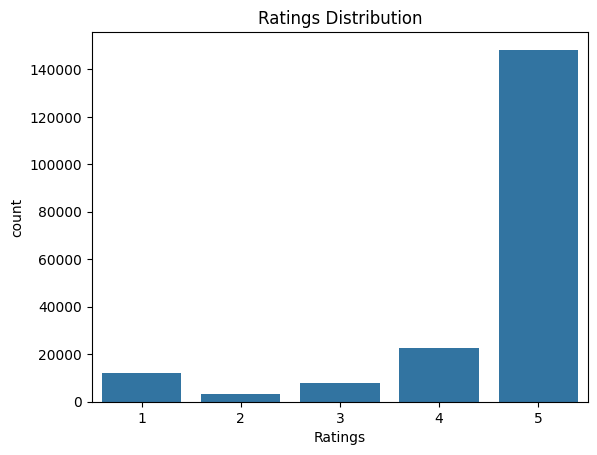

In [127]:
#Creating Rating Distribution Countplot
sns.countplot(x='Ratings', data=df)
plt.title("Ratings Distribution")
plt.show()

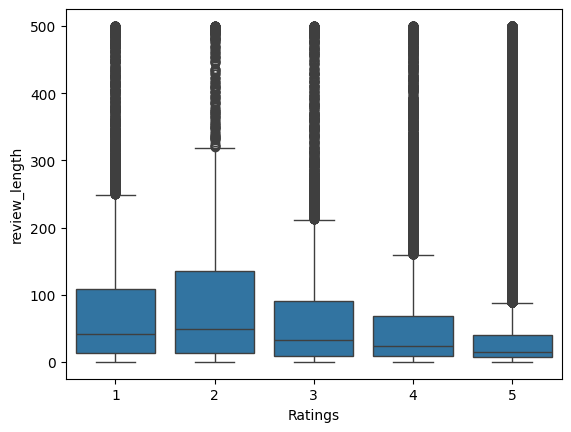

In [128]:
#Review Length Analysis using Boxplot

df['review_length'] = df['clean_review'].apply(len)
sns.boxplot(x='Ratings', y='review_length', data=df)
plt.show()

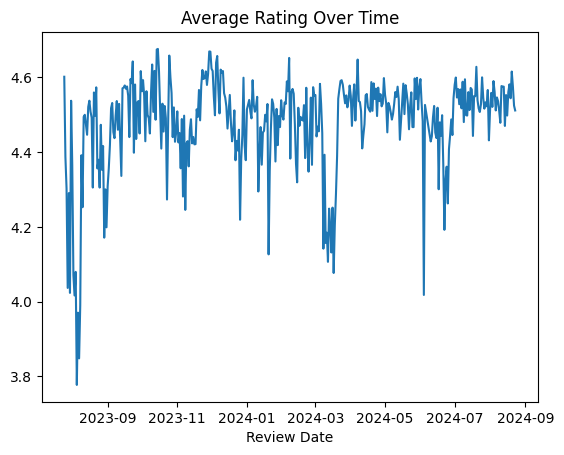

In [129]:
#Time-Series Trend of Reviews
#Line Chart
#Average Rating by date

daily = df.groupby(df['Review Date'].dt.date)['Ratings'].mean()
daily.plot(kind='line')
plt.title("Average Rating Over Time")
plt.show()

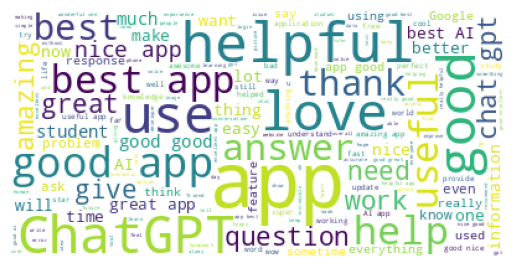

In [130]:
# Visually shows the most frequent words in user reviews.
# Quick way to identify common themes, popular features, or repeated complaints.
# For example, large words like “good”, “great”, or “accurate” indicate positive feedback; words like “slow” or “problem” may indicate issues.

words = " ".join(df['clean_review'])
wordcloud = WordCloud(background_color='white').generate(words)

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

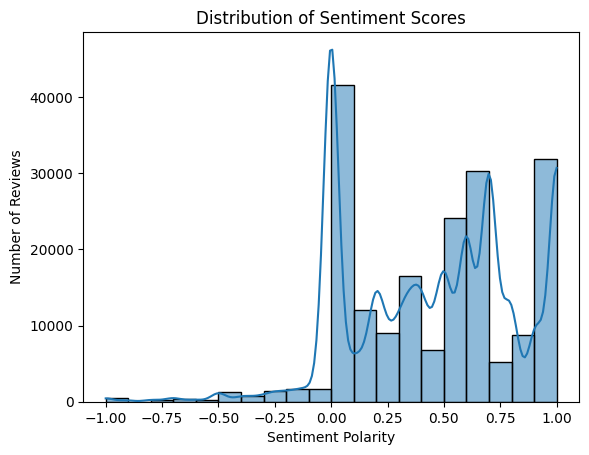

In [131]:
# TextBlob(text) creates a text object that can perform basic NLP tasks.
# .sentiment.polarity calculates the sentiment polarity of the text.
# Returns a value between -1 and 1:
# -1 → very negative
# 0 → neutral
# 1 → very positive
# The function get_sentiment takes a string text as input and outputs its sentiment score.

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

df['sentiment'] = df['clean_review'].apply(get_sentiment)

sns.histplot(df['sentiment'], bins=20, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Polarity")
plt.ylabel("Number of Reviews")
plt.show()

[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
/tmp/ipython-input-2130420376.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_words), y=list(pos_freqs), palette="Greens")


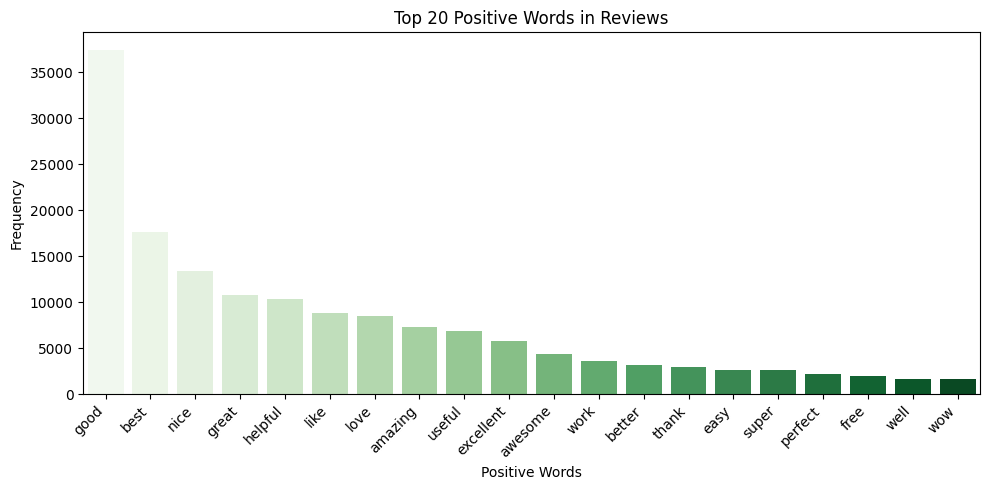

/tmp/ipython-input-2130420376.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_words), y=list(neg_freqs), palette="Reds")


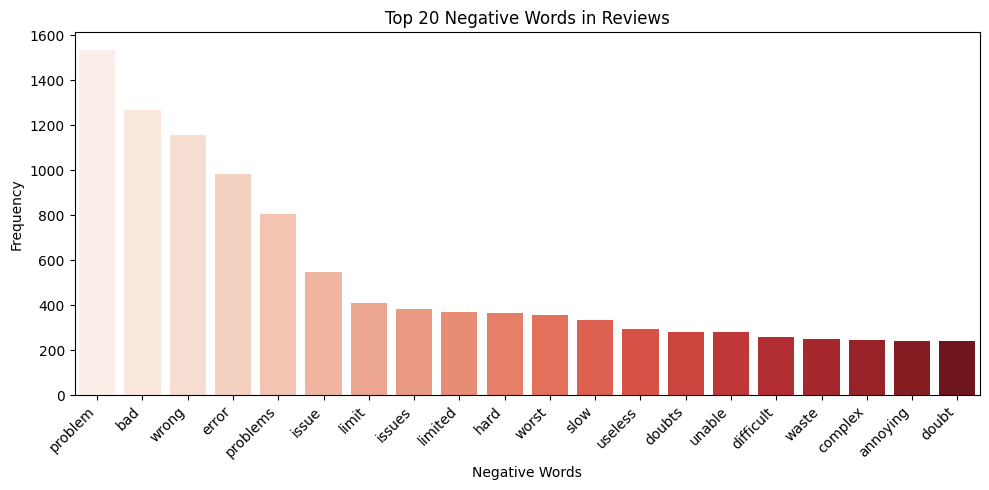

In [132]:
# Positive Words Chart: Shows words users use most when they are satisfied (e.g., "good", "great", "helpful").
# Negative Words Chart: Highlights complaints or areas of concern (e.g., "slow", "problem", "error").
# Useful for quick insight into strengths and weaknesses mentioned in reviews.

import nltk
from nltk.corpus import opinion_lexicon

nltk.download('opinion_lexicon')

positive_words = set(opinion_lexicon.positive())
negative_words = set(opinion_lexicon.negative())

all_words = " ".join(df['clean_review']).lower().split()

from collections import Counter

positive_counts = Counter([w for w in all_words if w in positive_words])
negative_counts = Counter([w for w in all_words if w in negative_words])

top_pos = positive_counts.most_common(20)
top_neg = negative_counts.most_common(20)

# positive words
pos_words, pos_freqs = zip(*top_pos)

plt.figure(figsize=(10,5))
sns.barplot(x=list(pos_words), y=list(pos_freqs), palette="Greens")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Positive Words in Reviews")
plt.xlabel("Positive Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# negative words
neg_words, neg_freqs = zip(*top_neg)

plt.figure(figsize=(10,5))
sns.barplot(x=list(neg_words), y=list(neg_freqs), palette="Reds")
plt.xticks(rotation=45, ha='right')
plt.title("Top 20 Negative Words in Reviews")
plt.xlabel("Negative Words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

/tmp/ipython-input-670282623.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=df, palette='viridis')


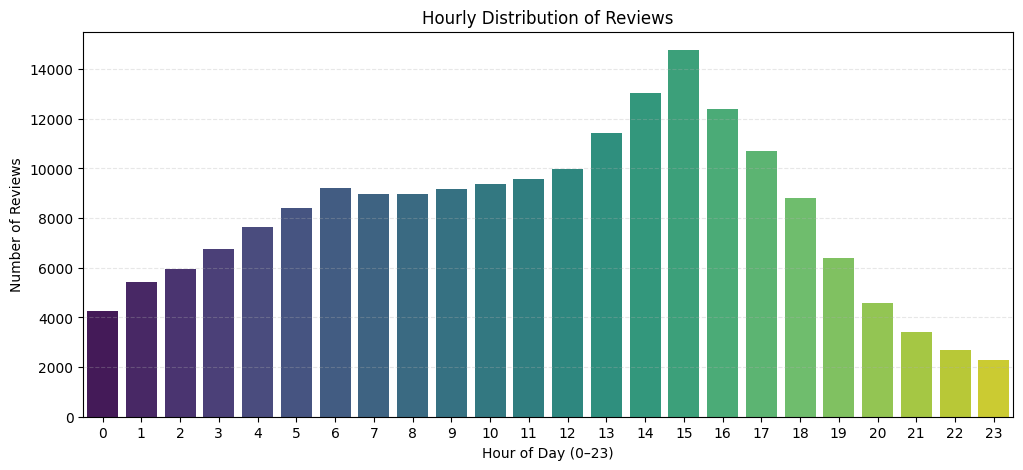

In [133]:
# Extract hour from timestamp
# The plot shows when users most frequently post reviews during the day.
# Peaks in certain hours (e.g., evening) reveal peak user activity times.
# This can help with scheduling product updates, customer support, or marketing.
# Lower bars indicate less review activity during those hours.

df['hour'] = df['Review Date'].dt.hour

plt.figure(figsize=(12,5))
sns.countplot(x='hour', data=df, palette='viridis')

plt.title("Hourly Distribution of Reviews")
plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

/tmp/ipython-input-1404499157.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='weekday', data=df, order=[


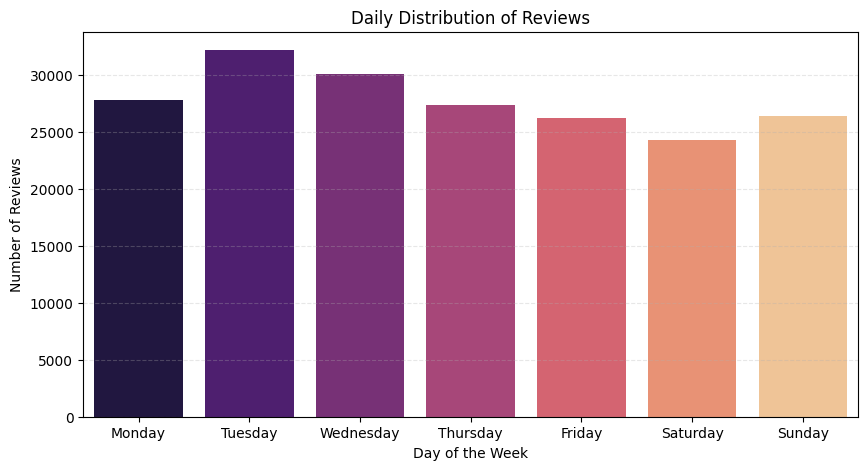

In [134]:
# This plot reveals which days of the week have higher or lower user review activity.
# It can help identify user engagement patterns and optimize timing for updates or campaigns.

df['weekday'] = df['Review Date'].dt.day_name()
plt.figure(figsize=(10,5))
sns.countplot(x='weekday', data=df, order=[
    'Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'
], palette='magma')

plt.title("Daily Distribution of Reviews")
plt.xlabel("Day of the Week")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()


/tmp/ipython-input-3729132948.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


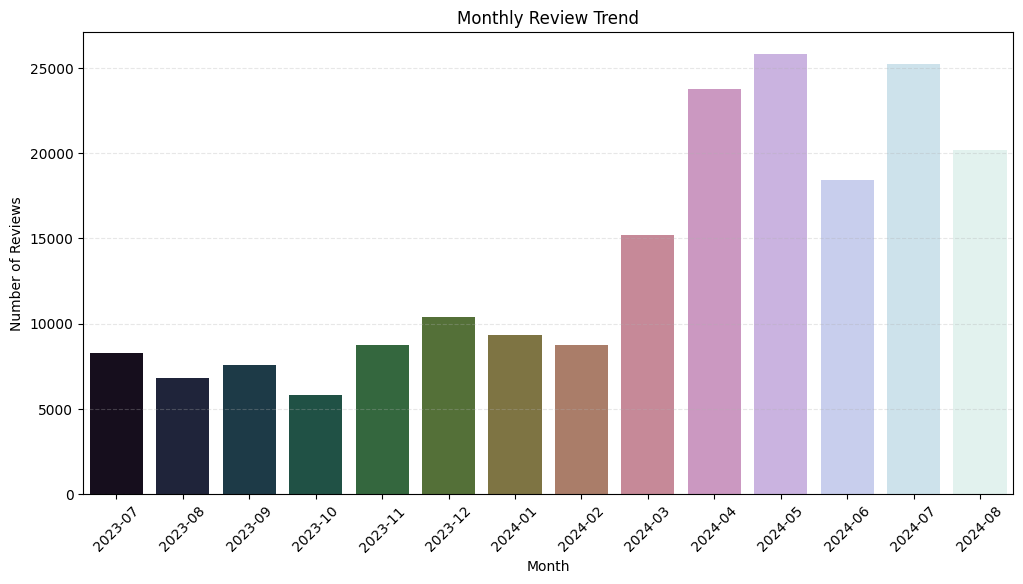

In [135]:
# This chart reveals how review activity changes over months.
# You can spot trends like growth, seasonality, or dips in user engagement.
# It helps in understanding the product’s popularity or feedback flow over time.

# Create month column as a proper period (not string)
df['month'] = df['Review Date'].dt.to_period('M')

# Get sorted unique months
sorted_months = sorted(df['month'].unique())

plt.figure(figsize=(12,6))
sns.countplot(
    x='month',
    data=df,
    order=sorted_months,          # pass sorted months
    palette='cubehelix'
)

plt.xticks(rotation=45)
plt.title("Monthly Review Trend")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()

